In [28]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn



import torchvision
import torchvision.transforms as transforms

from models import *   # bring everything in the folder models

global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')


batch_size = 128

# model_name = "cifar10"
model_name = "VGG16"
# model = cifar10()
model = VGG16()



normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 100 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()  # measure current time

    for i, (input, target) in enumerate(trainloader):
        # torch.Size([128, 3, 32, 32]) torch.Size([128])
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))



def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):

            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,5)):
    """Computes the precision@k for the specified values of k"""
    # print("Output shape:", output.shape, "e.g.", output[0])
    # print("Target shape:", target.shape, 'e.g.', target[0])
    # print("Topk:", topk)
    maxk = max(topk) # 5
    batch_size = target.size(0) # 128

    _, pred = output.topk(maxk, 1, True, True) # topk(k, dim=None, largest=True, sorted=True)
                                    # will output (max value, its index)
    pred = pred.t()               # transpose
    # print("Pred shape", pred.shape, pred[0])
    correct = pred.eq(target.view(1, -1).expand_as(pred))   # "-1": calculate automatically
    # print("Correct shape", correct.shape, correct[0])

    res = []
    for k in topk: # 1, 5
        # print("K", k)
        # correct_k = correct[:k].view(-1)  # view(-1): make a flattened 1D tensor
        correct_k = correct[:k].reshape(-1)
        # print("correct_k before sum:", correct_k.shape)
        correct_k = correct_k.float().sum(0)
        # print("correct_k after sum:", correct_k.shape)
        res.append(correct_k.mul_(100.0 / batch_size))   # correct: size of [maxk, batch_size]
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [150, 225]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

=> Building model...


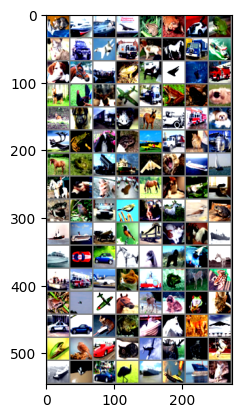

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images))


In [31]:
# This cell is from the website

lr = 0.003 # could be 0.005 or maybe even 0.025



weight_decay = 1e-4 # regularization (same as l2 loss penalty)
epochs = 30
best_prec = 0

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.85, weight_decay=weight_decay) # momentum maybe high
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')

fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)


for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train(trainloader, model, criterion, optimizer, epoch)

    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)


Epoch: [0][0/391]	Time 0.186 (0.186)	Data 0.141 (0.141)	Loss 0.1338 (0.1338)	Prec 96.094% (96.094%)
Epoch: [0][100/391]	Time 0.058 (0.056)	Data 0.026 (0.012)	Loss 0.0731 (0.0750)	Prec 96.875% (97.455%)
Epoch: [0][200/391]	Time 0.055 (0.058)	Data 0.004 (0.014)	Loss 0.0788 (0.0735)	Prec 97.656% (97.462%)
Epoch: [0][300/391]	Time 0.053 (0.057)	Data 0.002 (0.011)	Loss 0.1234 (0.0742)	Prec 95.312% (97.410%)
Validation starts
Test: [0/79]	Time 0.131 (0.131)	Loss 0.1973 (0.1973)	Prec 94.531% (94.531%)
 * Prec 90.050% 
best acc: 90.050000
Epoch: [1][0/391]	Time 0.222 (0.222)	Data 0.176 (0.176)	Loss 0.0349 (0.0349)	Prec 99.219% (99.219%)
Epoch: [1][100/391]	Time 0.051 (0.056)	Data 0.007 (0.009)	Loss 0.0601 (0.0557)	Prec 97.656% (98.074%)
Epoch: [1][200/391]	Time 0.053 (0.058)	Data 0.002 (0.014)	Loss 0.1379 (0.0578)	Prec 95.312% (97.983%)
Epoch: [1][300/391]	Time 0.059 (0.056)	Data 0.004 (0.012)	Loss 0.0206 (0.0582)	Prec 100.000% (97.968%)
Validation starts
Test: [0/79]	Time 0.126 (0.126)	Loss 0

In [32]:

fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)


Test: [0/79]	Time 0.158 (0.158)	Loss 0.3340 (0.3340)	Prec 93.750% (93.750%)
 * Prec 91.030% 


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# HW

#  1. train resnet20 and vgg16 to achieve >90% accuracy
#  2. save your trained model in the result folder
#  3. Restart your jupyter notebook by "Kernel - Restart & Clear Output"
#  4. Load your saved model for vgg16 and validate to see the accuracy
#  5. such as the last part of "[W2S2_example2]_CNN_for_MNIST.ipynb", prehook the input layers of all the conv layers.
#  6. from the first prehooked input, compute to get the second prehooked input.
#  7. Compare your computed second input vs. the prehooked second input.


In [ ]:
m = model.conv1

In [ ]:
(r(m(pre0) + pre0) - prec1).abs().sum()

In [38]:
    from google.colab import files
    import shutil

    shutil.make_archive("/content/result/VGG16", 'zip', "/content/result/VGG16")
    files.download("/content/result/VGG16.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>